In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from load_data import *
from flow_catlog import *
import flow_manager as fm
import autoencoder as ae
import classifier as clfr
from sampler import *
from utl import *
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

![workflow](../images/vuad.png)

## Load Data

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

datafile = 'machine-1-1.csv'
X_data = pd.read_csv(datafile, index_col=0)
X_data = X_data.values.astype(np.float32)
# X_data = StandardScaler().fit_transform(X_data)
X_data = MinMaxScaler().fit_transform(X_data)

X_train, X_test = train_test_split(X_data, test_size=.2)

In [3]:
# Common
lr = 1e-4

# Parameters for Normalizing Flow
num_bijectors = 4
epochs=20
batch_size=32
iaf_hidden_units = [256, 256]

# Parameters for AutoEncoder
latent_dim = 2
encoder_units = [64, 32]
decoder_units = [32, 64]

## Build Normalizing Flow

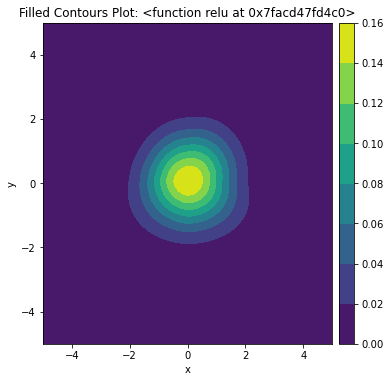

In [4]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([latent_dim], tf.float32))
flow_opt = tfk.optimizers.Adam(learning_rate=lr)
flow_model = IAF(base_dist, num_bijectors, hidden_units=iaf_hidden_units, ndims=latent_dim, activation=tf.nn.relu)
plot_contour_prob([flow_model], scale_fig=6, title=[tf.nn.relu])

## Build AutoEncoder & Train with Normalizing Flow

In [5]:
input_dim = X_train.shape[1]
encoder = ae.build_encoder(input_dim, latent_dim, hidden_units=encoder_units)
decoder = ae.build_decoder(input_dim, latent_dim, hidden_units=decoder_units)
autoencoder = ae.AutoEncoder(encoder, decoder, flow_model=flow_model, flow_opt=flow_opt)
autoencoder.compile()
history = autoencoder.fit(X_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/20
712/712 [==============================] - 19s 9ms/step - reconstruction_loss: 0.0081
Epoch 2/20
712/712 [==============================] - 7s 9ms/step - reconstruction_loss: 0.0033
Epoch 3/20
712/712 [==============================] - 7s 10ms/step - reconstruction_loss: 0.0025
Epoch 4/20
712/712 [==============================] - 7s 10ms/step - reconstruction_loss: 0.0021
Epoch 5/20
712/712 [==============================] - 8s 11ms/step - reconstruction_loss: 0.0020
Epoch 6/20
712/712 [==============================] - 7s 10ms/step - reconstruction_loss: 0.0020
Epoch 7/20
712/712 [==============================] - 6s 9ms/step - reconstruction_loss: 0.0019
Epoch 8/20
712/712 [==============================] - 7s 10ms/step - reconstruction_loss: 0.0019
Epoch 9/20
712/712 [==============================] - 7s 9ms/step - reconstruction_loss: 0.0018
Epoch 10/20
712/712 [==============================] - 7s 9ms/step - reconstruction_loss: 0.0018
Epoch 11/20
712/712 [============

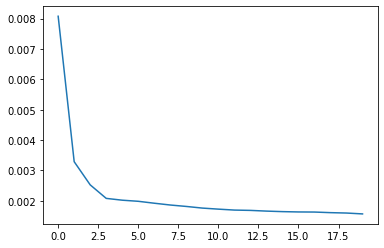

In [6]:
plt.plot(history.history['reconstruction_loss'])

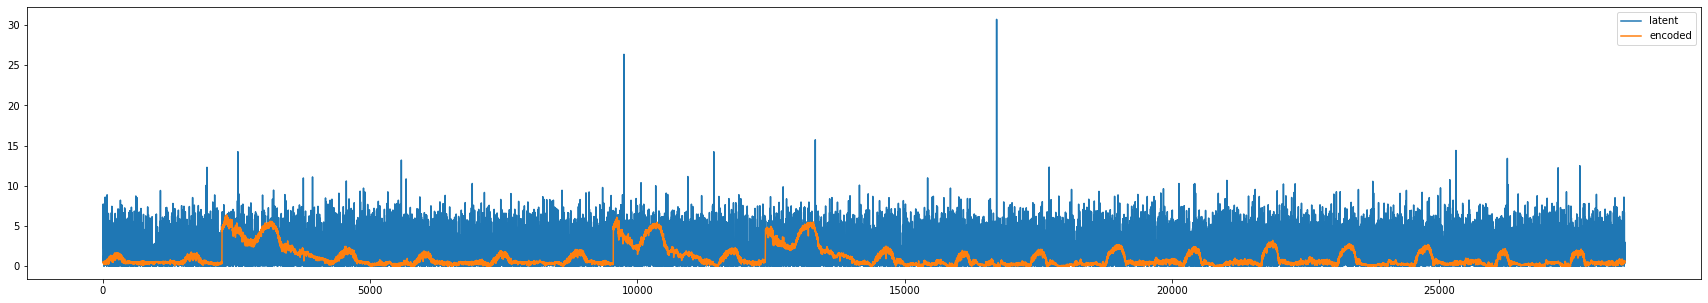

In [37]:
fig = plt.figure(figsize=(30, 5))
X_data_encoded = autoencoder.encoder(X_data)
temp = flow_model.sample(X_data_encoded.shape[0])
plt.plot(temp[:, 0], label='latent')
plt.plot(X_data_encoded[:, 0], label='encoded')
plt.legend()
plt.show()

## Supervised Anomaly Classifier

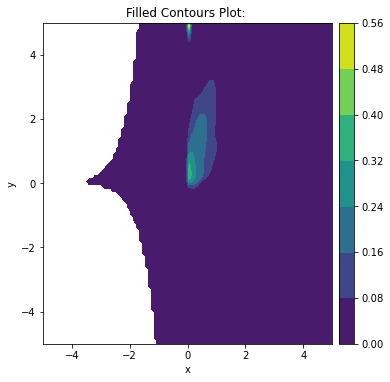

In [7]:
plot_contour_prob([flow_model], scale_fig=6)

In [8]:
factor = 2
anomalies = sample_anomalies(flow_model, factor=factor, n_samples=3000, sample_shape=latent_dim)
normals = sample_normals(flow_model, factor=factor, n_samples=10000, sample_shape=latent_dim)

anomalies = pd.DataFrame(anomalies)
normals = pd.DataFrame(normals)
anomalies.columns = ['v1', 'v2']
normals.columns = ['v1', 'v2']
anomalies['label'] = 1
normals['label'] = 0

clr_data = pd.concat([anomalies, normals], axis=0)
clr_data = clr_data.dropna()
clr_data = shuffle(clr_data)

In [9]:
clf_X_train, clf_X_test, clf_y_train, clf_y_test = train_test_split(clr_data[['v1', 'v2']], clr_data['label'], test_size=0.33, random_state=42)
clf, score = clfr.RFClassifier(clf_X_train, clf_y_train, clf_X_test, clf_y_test)
print('precision: {}'.format(score[0]))
print('recall: {}'.format(score[1]))
print('fscore: {}'.format(score[2]))

precision: [1. 1.]
recall: [1. 1.]
fscore: [1. 1.]


## Evaluate Flow Model and AutoEncoder

In [10]:
# encode data
X_data_encoded = autoencoder.encoder.predict(X_data)

# classify anomalies, note the classifies is built based on flow model
y_data_encoded = clf.predict(X_data_encoded)
y_data_encoded_anomalies = np.where(y_data_encoded == 1)

# decode data from latent space
X_data_decoded = autoencoder.decoder.predict(X_data_encoded)
X_data_decoded.shape

(28478, 28)

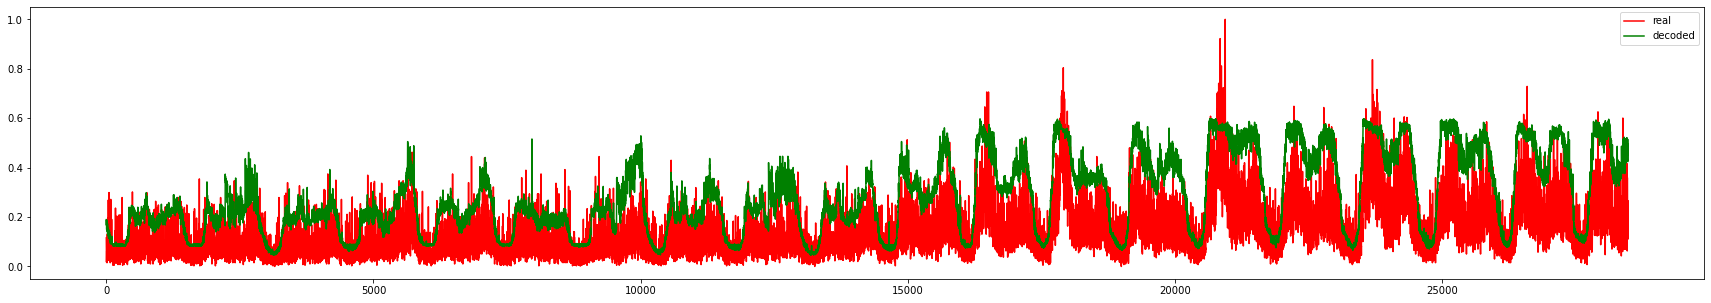

In [11]:
fig = plt.figure(figsize=(30, 5))
x = np.arange(len(X_data_decoded[:, 0]))
plt.plot(x, X_data[:, 0], color='red', zorder=0, label='real')
plt.plot(x, X_data_decoded[:, 0], color='green', zorder=1, label='decoded')

plt.legend()
plt.show()

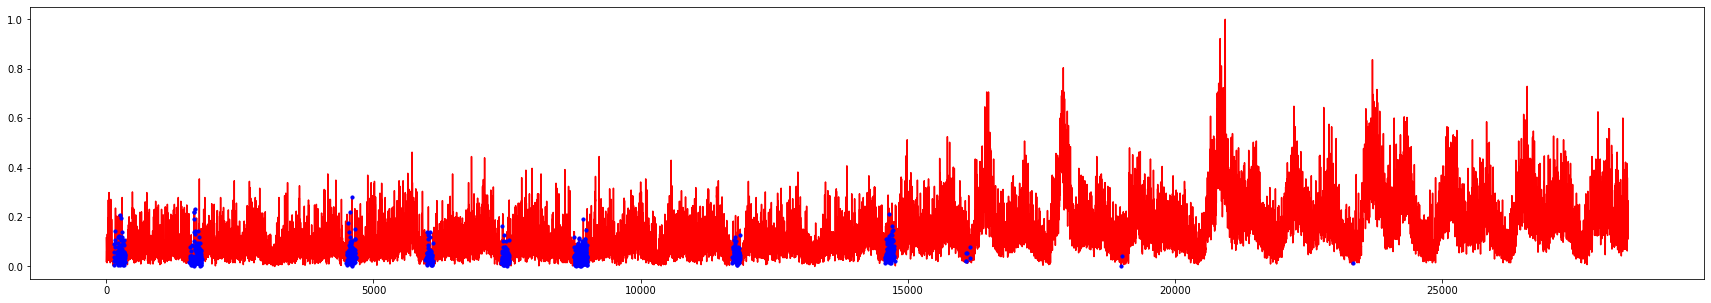

In [16]:
fig = plt.figure(figsize=(30, 5))
x = np.arange(len(X_data[:, 0]))
plt.plot(x, X_data[:, 0], color='red', zorder=0)
plt.scatter(y_data_encoded_anomalies, X_data[y_data_encoded_anomalies, 0], s=10, color='blue', zorder=1)
plt.show()